In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers

import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [2]:
## DOWNLOAD CSV DATASETS FROM ANALYZE BOSTON

# Create a data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# List of URLs for each year's data
urls = [
    'https://data.boston.gov/datastore/dump/6b3c5333-1dcb-4b3d-9cd7-6a03fb526da7?bom=True',  # 2023
    'https://data.boston.gov/datastore/dump/63ac638b-36c4-487d-9453-1d83eb5090d2?bom=True',  # 2022
    'https://data.boston.gov/datastore/dump/ec5aaf93-1509-4641-9310-28e62e028457?bom=True',  # 2021
    'https://data.boston.gov/datastore/dump/e2e2c23a-6fc7-4456-8751-5321d8aa869b?bom=True',  # 2020
    'https://data.boston.gov/datastore/dump/3bdfe6dc-3a81-49ce-accc-22161e2f7e74?bom=True',  # 2019
    'https://data.boston.gov/datastore/dump/31358fd1-849a-48e0-8285-e813f6efbdf1?bom=True',  # 2018
    'https://data.boston.gov/datastore/dump/70129b87-bd4e-49bb-aa09-77644da73503?bom=True',  # 2017
    'https://data.boston.gov/datastore/dump/8368bd3d-3633-4927-8355-2a2f9811ab4f?bom=True',  # 2016
    'https://data.boston.gov/datastore/dump/2ff6343f-850d-46e7-98d1-aca79b619fd6?bom=True',  # 2015
    'https://data.boston.gov/datastore/dump/941c9de4-fb91-41bb-ad5a-43a35f5dc80f?bom=True'   # 2014
]

# Loop over the URLs and download each CSV
start_year = 2023
for i, url in enumerate(urls):
    year = start_year - i
    response = requests.get(url)
    # Check if the request was successful
    if response.status_code == 200:
        filename = f'data/data_{year}.csv' # Name file by year
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f'Successfully downloaded data for {year}')
    else:
        print(f'Failed to download data for {year}. Status code: {response.status_code}')

# Load and combine all CSVs into a single DataFrame
dataframes = []
for year in range(2023, 2013, -1):
    df = pd.read_csv(f'data/data_{year}.csv')
    df['year'] = year  # Add a column for the year
    dataframes.append(df)

# Combine all DataFrames into one
all_data = pd.concat(dataframes, ignore_index=True)

# Display the combined data
print(all_data.head(10))


Successfully downloaded data for 2023
Successfully downloaded data for 2022
Successfully downloaded data for 2021
Successfully downloaded data for 2020
Successfully downloaded data for 2019
Successfully downloaded data for 2018
Successfully downloaded data for 2017
Successfully downloaded data for 2016
Successfully downloaded data for 2015
Successfully downloaded data for 2014
   _id                   NAME           DEPARTMENT_NAME  \
0    1       Demesmin,Stanley  Boston Police Department   
1    2          Hosein,Haseeb  Boston Police Department   
2    3        Conway,Kendra J  Boston Police Department   
3    4           Smith,Sean P  Boston Police Department   
4    5       Danilecki,John H  Boston Police Department   
5    6          Gero,Jarrod A  Boston Police Department   
6    7         Skipper,Mary E   Superintendent's Office   
7    8       Connolly,Timothy  Boston Police Department   
8    9  Grandson IV,Charles A                  Strategy   
9   10      Barrett,Thomas E. 

### From the add_data.head() above, we can see that due to each csv file having a different naming convention for headers, the data is a mess. The first step of the data cleaning is thus to standardize the data headers.


In [3]:
## ADD YEAR COLUMN TO EACH CSV FILE
data_dir = 'data'

# Loop through each CSV file in the data directory
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        # Extract the year from the filename
        year = filename.split('_')[1].split('.')[0]
        
        # Read the CSV file into a DataFrame
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)
        
        # Check if 'year' column exists, and if not, add it
        if 'year' not in df.columns:
            df['year'] = int(year)
            # Save the updated DataFrame back to the CSV file
            df.to_csv(file_path, index=False)
            print(f"Added 'year' column to {filename}")
        else:
            print(f"'year' column already exists in {filename}")


Added 'year' column to data_2021.csv
Added 'year' column to data_2020.csv
Added 'year' column to data_2022.csv
Added 'year' column to data_2023.csv
Added 'year' column to data_2018.csv
Added 'year' column to data_2019.csv
Added 'year' column to data_2014.csv
Added 'year' column to data_2015.csv
Added 'year' column to data_2017.csv
Added 'year' column to data_2016.csv


In [4]:
## ANALYZE CSV FILE HEADERS

headers_dict = {}
# Loop through each CSV file in the data directory
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        # Extract the year from the filename
        year = int(filename.split('_')[1].split('.')[0])
        
        # Read only the header row
        df = pd.read_csv(os.path.join(data_dir, filename), nrows=0)
        
        # Store the headers in the dictionary
        headers_dict[year] = list(df.columns)

# Display all headers for each year
for year, headers in headers_dict.items():
    print(f"Year: {year}, Headers: {headers}")
    print("-" * 80)

Year: 2021, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION_INCENTIVE', 'TOTAL_GROSS', 'POSTAL', 'year']
--------------------------------------------------------------------------------
Year: 2020, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN / EDUCATION INCENTIVE', 'TOTAL EARNINGS', 'POSTAL', 'year']
--------------------------------------------------------------------------------
Year: 2022, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION', 'TOTAL_ GROSS', 'POSTAL', 'year']
--------------------------------------------------------------------------------
Year: 2023, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION', 'TOTAL GROSS', 'POSTAL', 'year']
---------------

In [5]:
## STANDARDIZE COLUMN NAMES

# Target headers mapping to standardize all headers to the 2023 version
target_headers = {
    '_id': '_id',
    'NAME': 'NAME',
    'TITLE': 'TITLE',
    'DEPARTMENT NAME': 'DEPARTMENT_NAME',
    'DEPARTMENT_NAME': 'DEPARTMENT_NAME',
    'REGULAR': 'REGULAR',
    'RETRO': 'RETRO',
    'OTHER': 'OTHER',
    'OVERTIME': 'OVERTIME',
    'INJURED': 'INJURED',
    'DETAIL': 'DETAIL',
    'DETAILS': 'DETAIL',
    'QUINN': 'QUINN_EDUCATION',
    'QUINN/EDUCATION INCENTIVE': 'QUINN_EDUCATION',
    'QUINN / EDUCATION INCENTIVE': 'QUINN_EDUCATION',
    'QUINN_EDUCATION_INCENTIVE': 'QUINN_EDUCATION',
    'QUINN_EDUCATION': 'QUINN_EDUCATION',
    'TOTAL EARNINGS': 'TOTAL_GROSS',
    'TOTAL_ GROSS': 'TOTAL_GROSS',
    'TOTAL GROSS': 'TOTAL_GROSS',
    'ZIP': 'POSTAL',
    'POSTAL': 'POSTAL',
    'year': 'year'
}

# Standardize headers for each CSV file
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_dir, filename)
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Rename columns according to target headers
        df.rename(columns=target_headers, inplace=True)
        
        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path, index=False)
        print(f"Standardized headers for {filename}")


Standardized headers for data_2021.csv
Standardized headers for data_2020.csv
Standardized headers for data_2022.csv
Standardized headers for data_2023.csv
Standardized headers for data_2018.csv
Standardized headers for data_2019.csv
Standardized headers for data_2014.csv
Standardized headers for data_2015.csv
Standardized headers for data_2017.csv
Standardized headers for data_2016.csv


In [6]:
## CHECK CSV HEADERS AFTER STANDARDIZATION

# Loop through each CSV file in the data directory
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        # Extract the year from the filename
        year = filename.split('_')[1].split('.')[0]
        
        # Read only the header row
        df = pd.read_csv(os.path.join(data_dir, filename), nrows=0)
        
        # Store the headers in the dictionary
        headers_dict[year] = list(df.columns)

# Display all headers for each year
for year, headers in headers_dict.items():
    print(f"Year: {year}, Headers: {headers}")
    print("-" * 80)

Year: 2021, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION_INCENTIVE', 'TOTAL_GROSS', 'POSTAL', 'year']
--------------------------------------------------------------------------------
Year: 2020, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN / EDUCATION INCENTIVE', 'TOTAL EARNINGS', 'POSTAL', 'year']
--------------------------------------------------------------------------------
Year: 2022, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION', 'TOTAL_ GROSS', 'POSTAL', 'year']
--------------------------------------------------------------------------------
Year: 2023, Headers: ['_id', 'NAME', 'DEPARTMENT_NAME', 'TITLE', 'REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION', 'TOTAL GROSS', 'POSTAL', 'year']
---------------

With the data now being standardized across years, because the employee earnings data contains data for every public servant under the payroll of Boston, we need to extract the data only related to BPD (DEPARTMENT_NAME="Boston Police Department").

In [7]:
## EXTRACT DATA RELATED TO BPD

# Initialize an empty list to store filtered DataFrames
bpd_data = []

# Loop through each CSV file in the data directory
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_dir, filename)
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Check if 'DEPARTMENT_NAME' column exists (in case of unexpected missing columns)
        if 'DEPARTMENT_NAME' in df.columns:
            # Filter rows where DEPARTMENT_NAME is "Boston Police Department"
            bpd_df = df[df['DEPARTMENT_NAME'] == "Boston Police Department"]
            # Append the filtered data to the list
            bpd_data.append(bpd_df)
        else:
            print(f"DEPARTMENT_NAME column missing in {filename}")

# Concatenate all filtered DataFrames
merged_bpd_data = pd.concat(bpd_data, ignore_index=True)

# Save the merged DataFrame to a CSV file
merged_bpd_data.to_csv('BPD_salary.csv', index=False)
print("Merged data saved to BPD_salary.csv")


Merged data saved to BPD_salary.csv


## After this, there is still a problem with the numerical data columns, as some are prefixed with the `$` symbol and some are not. For easy data processing in the future, let us remove the use of `$` symbols altogether and convert the columns to a float type.

### NOTE:
    There is also an abnormal row with an abnormal salary that we took account of:  
    16,"Hartgrove,Christopher A",Police Detective,Boston Police Department,($380.71),$174.05 ,"$16,078.64 ",,"$106,392.37 ",,,"$122,264.35 ",2066,2017


In [8]:
## REMOVE $ SYMBOLS FROM SALARY COLUMNS

# Load the merged data
bpd_data = pd.read_csv('BPD_salary.csv')

# List of salary categories to clean
salary_categories = ['REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION', 'TOTAL_GROSS']

# Clean each salary category column
for category in salary_categories:
    if category in bpd_data.columns:
        # Remove '$' symbol and handle negative values in parentheses
        bpd_data[category] = bpd_data[category].replace('[\$,]', '', regex=True)  # Remove $ symbol
        bpd_data[category] = bpd_data[category].replace(r'\(([^)]+)\)', r'-\1', regex=True)  # Convert (value) to -value
        bpd_data[category] = pd.to_numeric(bpd_data[category], errors='coerce')  # Convert to float, setting non-numeric values to NaN

# Save the cleaned data back to the file
bpd_data.to_csv('BPD_salary.csv', index=False)
print("Standardized salary columns in BPD_salary.csv, handling $ symbols and negative values in parentheses")


Standardized salary columns in BPD_salary.csv, handling $ symbols and negative values in parentheses


In [9]:
bpd_data.OTHER

0        1264843.63
1        1252990.81
2         212739.48
3         211900.28
4         192097.54
            ...    
31201        800.00
31202       8793.52
31203       3300.00
31204       5207.64
31205      46875.56
Name: OTHER, Length: 31206, dtype: float64

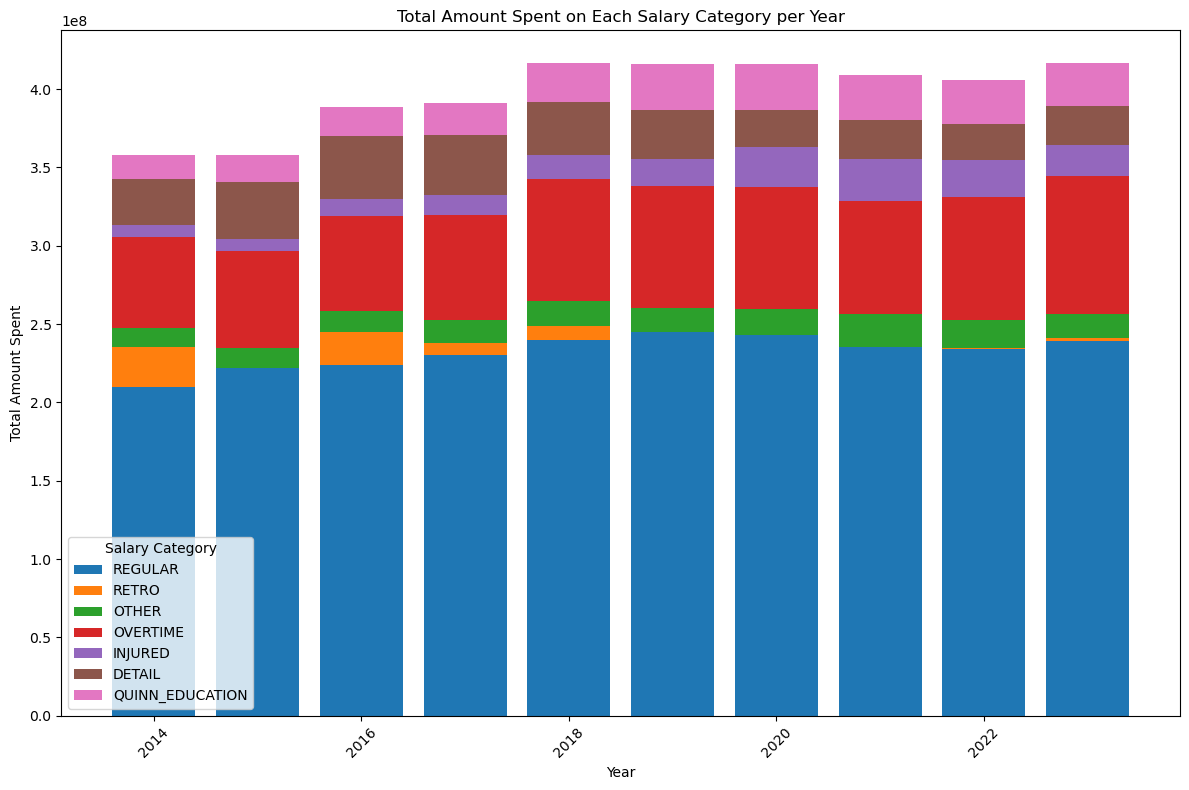

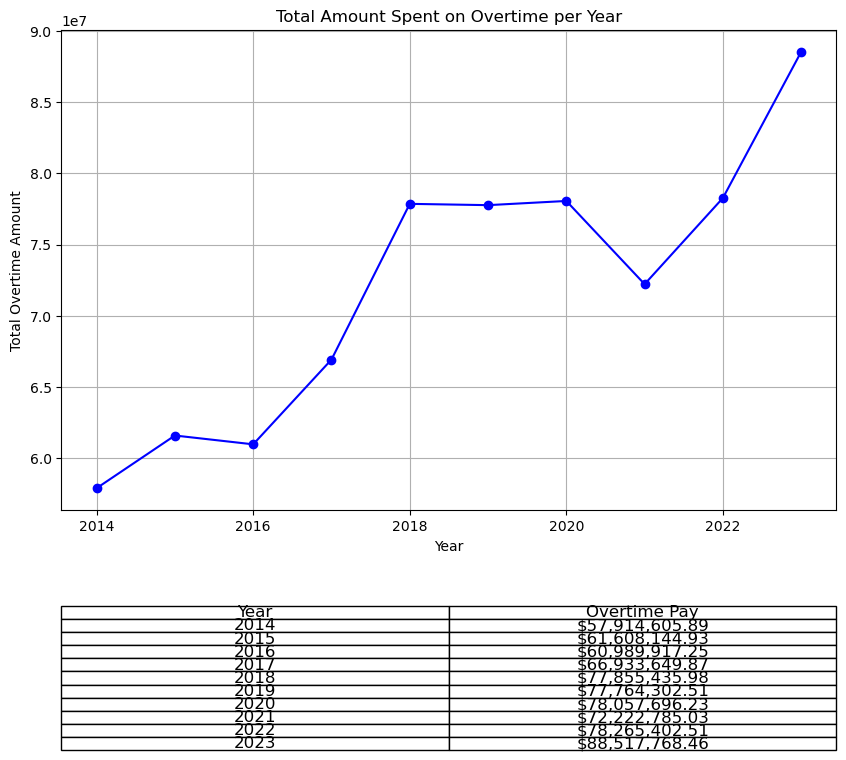

In [10]:
## PLOT GENERAL AND OVERTIME SALARY TREND

# Load the merged data
bpd_data = pd.read_csv('BPD_salary.csv')

# List of salary categories to analyze
salary_categories = ['REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION']

# Group by 'year' and calculate the total amount spent for each salary category
yearly_totals = bpd_data.groupby('year')[salary_categories].sum()

# Plot a stacked bar chart
plt.figure(figsize=(12, 8))
bottom = None  # For stacking bars

# Iterate through each category to plot each as a stacked component
for category in salary_categories:
    if bottom is None:
        bottom = yearly_totals[category]
        plt.bar(yearly_totals.index, yearly_totals[category], label=category)
    else:
        plt.bar(yearly_totals.index, yearly_totals[category], bottom=bottom, label=category)
        bottom += yearly_totals[category]  # Update the bottom position for stacking

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Amount Spent')
plt.title('Total Amount Spent on Each Salary Category per Year')
plt.legend(title="Salary Category")
plt.xticks(rotation=45)  # Rotate year labels if necessary
plt.tight_layout()

# Show the plot
plt.show()

# Group by 'year' and calculate the total amount spent on overtime
overtime_totals = bpd_data.groupby('year')['OVERTIME'].sum()

# Create a figure with two subplots: one for the plot and one for the table
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the overtime totals
ax.plot(overtime_totals.index, overtime_totals.values, marker='o', linestyle='-', color='b', label='Overtime')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Total Overtime Amount')
ax.set_title('Total Amount Spent on Overtime per Year')
ax.grid(True)

# Prepare the table data
table_data = [[year, f"${amount:,.2f}"] for year, amount in zip(overtime_totals.index, overtime_totals.values)]
column_labels = ["Year", "Overtime Pay"]

# Create a larger table and increase font size
table = plt.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)

# Adjust layout to make room for the larger table
plt.subplots_adjust(bottom=0.4)

# Display the plot with the larger table
plt.show()




Percentage of Officers Receiving Injury Pay in 2014-2023: 41.00%
Average Total Injury Pay (2014-2023) for Officers Receiving Injury Pay: $84,408.16


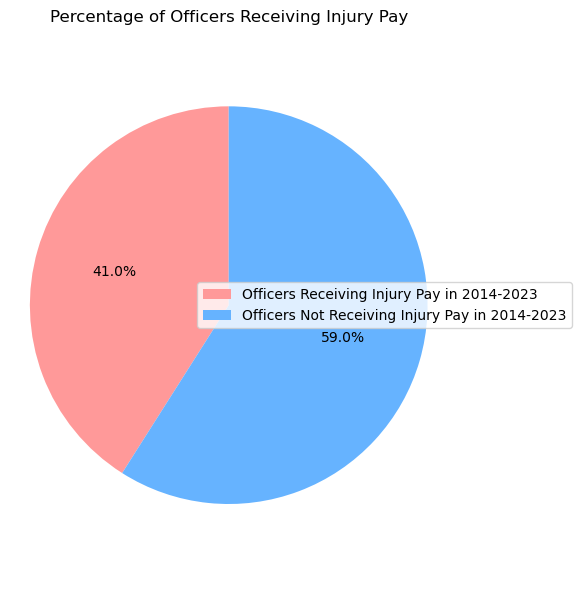

In [11]:
# Replace NaNs in INJURED with 0 for ease of calculation
bpd_data['INJURED'] = bpd_data['INJURED'].fillna(0)

# 1. Identify total amount of injury pay
total_injury_pay = bpd_data['INJURED'].sum()

# 2. Calculate the percentage of officers receiving injury pay
total_officers = bpd_data['NAME'].nunique()
officers_with_injury_pay = bpd_data.loc[bpd_data['INJURED'] > 0, 'NAME'].nunique()
percentage_injury = (officers_with_injury_pay / total_officers) * 100

# 3. Calculate the average total injury pay per officer (only those receiving injury pay)
officers_with_injury = bpd_data[bpd_data['INJURED'] > 0]
officer_injury_sums = officers_with_injury.groupby('NAME')['INJURED'].sum()
avg_injury_pay_for_recipients = officer_injury_sums.mean()

print(f"Percentage of Officers Receiving Injury Pay in 2014-2023: {percentage_injury:.2f}%")
print(f"Average Total Injury Pay (2014-2023) for Officers Receiving Injury Pay: ${avg_injury_pay_for_recipients:,.2f}")

# Create the pie chart
import matplotlib.pyplot as plt

percentage_no_injury = 100 - percentage_injury
labels = [
    'Officers Receiving Injury Pay in 2014-2023',
    'Officers Not Receiving Injury Pay in 2014-2023'
]
sizes = [percentage_injury, percentage_no_injury]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(6,6))
patches, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a legend inside the graph, to the right side
plt.legend(patches, labels, loc='center right', bbox_to_anchor=(1.3, 0.5))

plt.title('Percentage of Officers Receiving Injury Pay')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('injury_pay_distribution.png', dpi=200, bbox_inches='tight')
plt.show()


In [12]:
eth= pd.read_excel('PRR_9_4_2020.xls', header=1)
com = eth[['LN,FN','Job Title','Ethnic Grp','Sex','Sal Plan']]
# Assuming full_data and eth are already defined
# Drop duplicates in eth['Job Data with Academy Date'], keeping the last occurrence
com = com.drop_duplicates(subset=['LN,FN'], keep='last')

merged_data = bpd_data.merge(
    com, 
    left_on=['NAME', 'TITLE'],
    right_on=['LN,FN', 'Job Title'],
    how='inner'
)




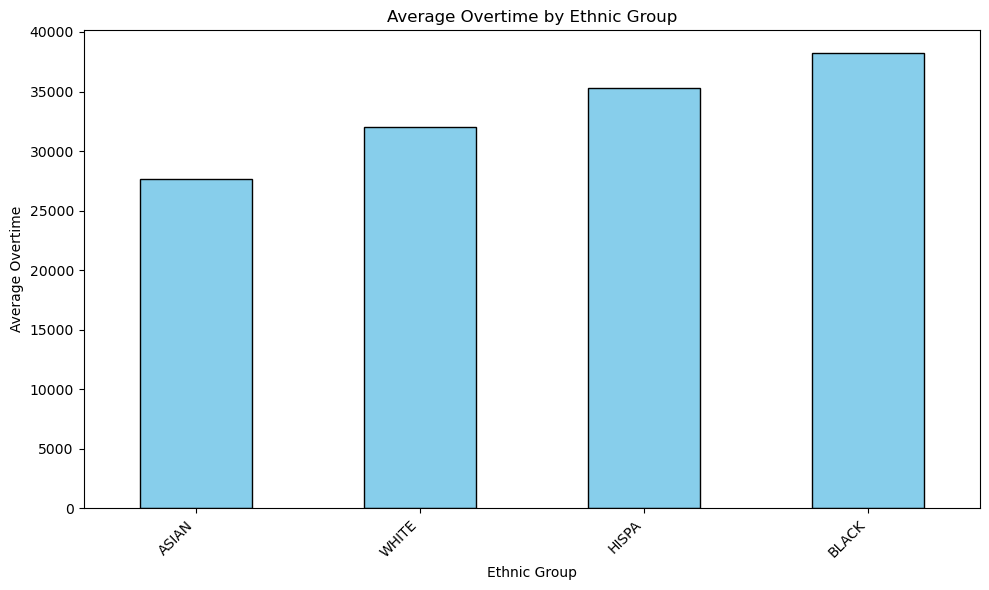

1.3820502662211536


In [13]:


# Group the data by "Ethnic Grp" and calculate the mean of "OVERTIME"
mean_overtime = merged_data.groupby('Ethnic Grp')['OVERTIME'].mean().sort_values()

# Create the plot
plt.figure(figsize=(10, 6))
mean_overtime.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Ethnic Group')
plt.ylabel('Average Overtime')
plt.title('Average Overtime by Ethnic Group')

# Optionally rotate x-axis labels if they are long
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()
print(merged_data.groupby('Ethnic Grp')['OVERTIME'].mean().BLACK/merged_data.groupby('Ethnic Grp')['OVERTIME'].mean().ASIAN)

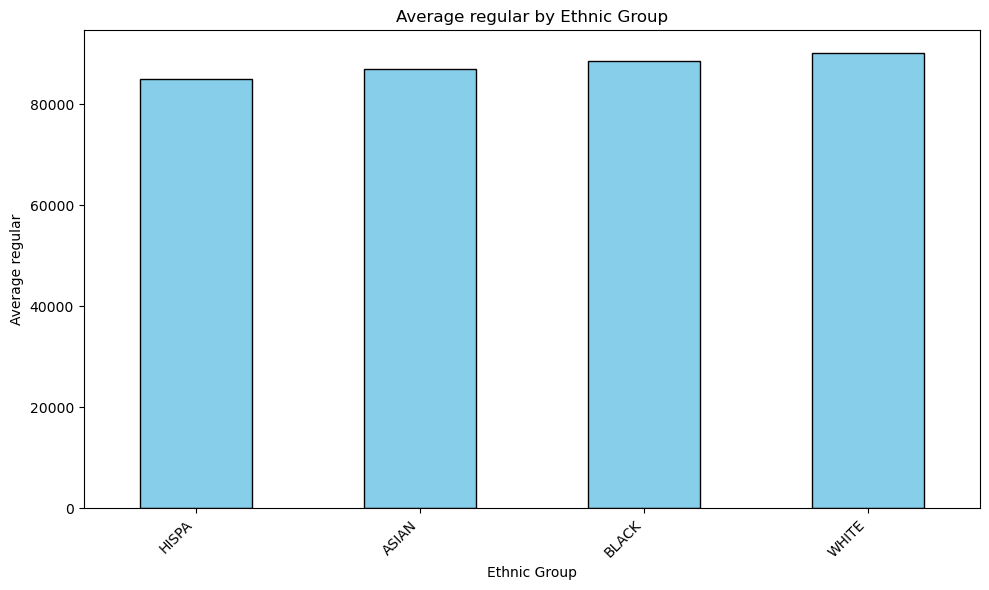

1.018078061703054


In [14]:

# Group the data by "Ethnic Grp" and calculate the mean of "OVERTIME"
mean_overtime = merged_data.groupby('Ethnic Grp')['REGULAR'].mean().sort_values()

# Create the plot
plt.figure(figsize=(10, 6))
mean_overtime.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Ethnic Group')
plt.ylabel('Average regular')
plt.title('Average regular by Ethnic Group')

# Optionally rotate x-axis labels if they are long
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()
print(merged_data.groupby('Ethnic Grp')['REGULAR'].mean().BLACK/merged_data.groupby('Ethnic Grp')['REGULAR'].mean().ASIAN)

### black earn 1.8% of regular salary more than Asian but 38% more on overtime

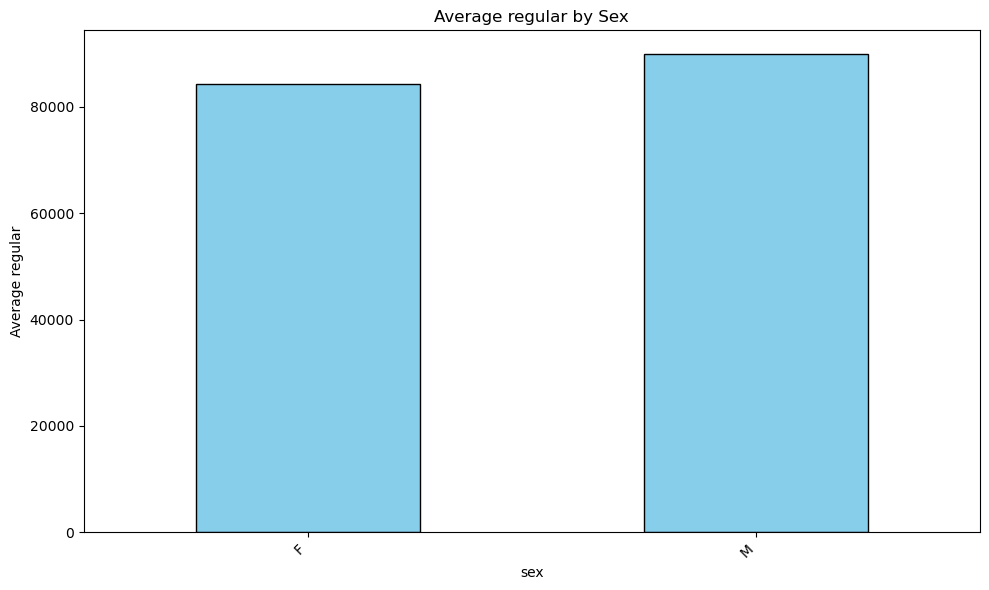

1.06603862207055


In [15]:

# Group the data by "Ethnic Grp" and calculate the mean of "OVERTIME"
mean_overtime = merged_data.groupby('Sex')['REGULAR'].mean().sort_values()

# Create the plot
plt.figure(figsize=(10, 6))
mean_overtime.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('sex')
plt.ylabel('Average regular')
plt.title('Average regular by Sex')

# Optionally rotate x-axis labels if they are long
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()
print(merged_data.groupby('Sex')['REGULAR'].mean().M/merged_data.groupby('Sex')['REGULAR'].mean().F)

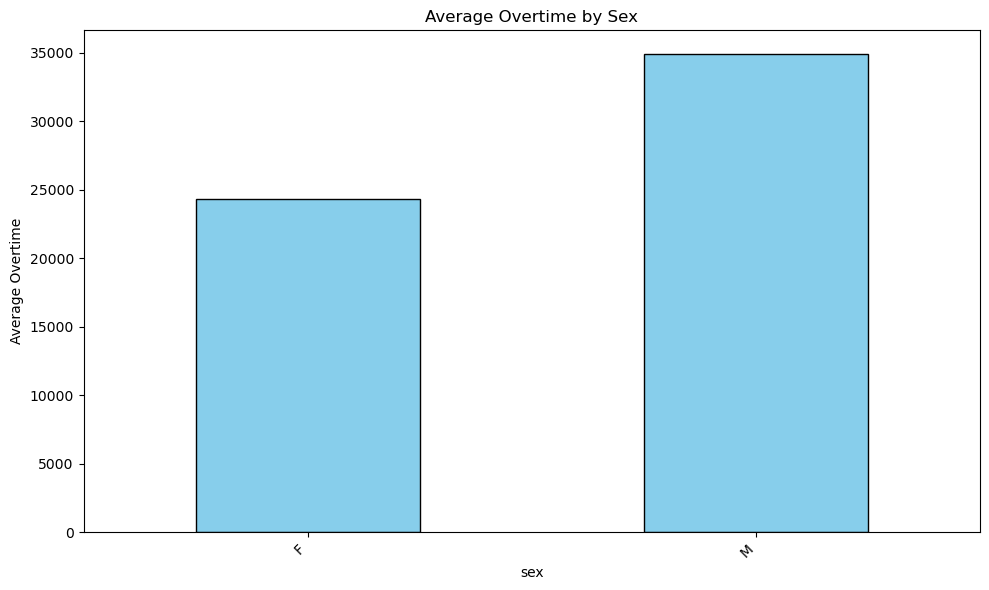

1.4331336738030733


In [16]:

# Group the data by "Ethnic Grp" and calculate the mean of "OVERTIME"
mean_overtime = merged_data.groupby('Sex')['OVERTIME'].mean().sort_values()

# Create the plot
plt.figure(figsize=(10, 6))
mean_overtime.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('sex')
plt.ylabel('Average Overtime')
plt.title('Average Overtime by Sex')

# Optionally rotate x-axis labels if they are long
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()
print(merged_data.groupby('Sex')['OVERTIME'].mean().M/merged_data.groupby('Sex')['OVERTIME'].mean().F)

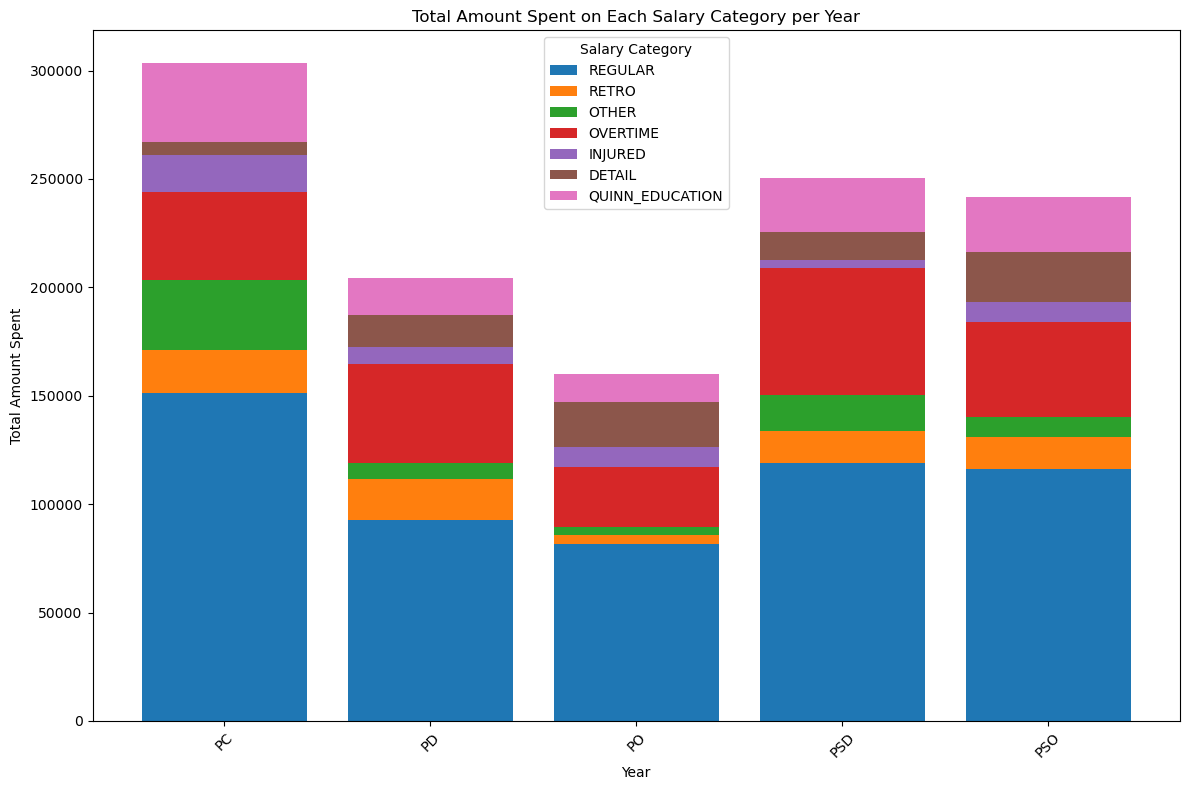

In [17]:
salary_categories = ['REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION']

# Group by 'year' and calculate the total amount spent for each salary category
sal_total = merged_data.groupby('Sal Plan')[salary_categories].mean()
sal_total = sal_total.drop('PC1', errors='ignore')  # Drop PC1 if it exists

# Plot a stacked bar chart
plt.figure(figsize=(12, 8))
bottom = None  # For stacking bars

# Iterate through each category to plot each as a stacked component
for category in salary_categories:
    if bottom is None:
        bottom = sal_total[category]
        plt.bar(sal_total.index, sal_total[category], label=category)
    else:
        plt.bar(sal_total.index, sal_total[category], bottom=bottom, label=category)
        bottom += sal_total[category]  # Update the bottom position for stacking

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Amount Spent')
plt.title('Total Amount Spent on Each Salary Category per Year')
plt.legend(title="Salary Category")
plt.xticks(rotation=45)  # Rotate year labels if necessary
plt.tight_layout()

# Show the plot
plt.savefig('total_amount_spent.png', dpi=300, bbox_inches='tight')
plt.show()


# Data Preprocessing 

In [18]:
#import pandas as pd

# Load the data
data = merged_data

# Check for missing values
missing_info = data.isnull().sum()
print("Missing value information:")
print(missing_info)


Missing value information:
_id                    0
NAME                   0
DEPARTMENT_NAME        0
TITLE                  0
REGULAR              715
RETRO              11956
OTHER                329
OVERTIME            1401
INJURED                0
DETAIL              4909
QUINN_EDUCATION     5793
TOTAL_GROSS            0
POSTAL                 7
year                   0
LN,FN                  0
Job Title              0
Ethnic Grp             0
Sex                    0
Sal Plan               4
dtype: int64


In [19]:
threshold = 0.8
data = data.loc[:, data.isnull().mean() < threshold]

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna('Unknown')



In [20]:
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')
data.columns

Index(['_id', 'name', 'department_name', 'title', 'regular', 'retro', 'other',
       'overtime', 'injured', 'detail', 'quinn_education', 'total_gross',
       'postal', 'year', 'ln,fn', 'job_title', 'ethnic_grp', 'sex',
       'sal_plan'],
      dtype='object')

In [21]:
salary_columns = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail', 'quinn_education', 'total_gross']
data[salary_columns] = data[salary_columns].apply(pd.to_numeric, errors='coerce')
data_full=data

In [22]:
data = data.drop(columns=['_id', 'name', 'name', 'title', 'department_name','ln,fn', 'job_title'])
data

,regular,retro,other,overtime,injured,detail,quinn_education,total_gross,postal,year,ethnic_grp,sex,sal_plan
0,69772.10,3170.12,212739.48,82300.870,30939.24,12144.0,25178.06,433073.75,02130,2021,BLACK,M,PO
1,106599.67,3170.12,10652.32,120358.270,0.00,27784.0,13422.61,278816.87,02130,2020,BLACK,M,PO
2,100711.34,3170.12,13552.31,102722.120,0.00,12880.0,25178.06,255043.83,02130,2022,BLACK,M,PO
3,100711.34,3170.12,14913.27,115402.750,0.00,22176.0,25178.06,278381.42,02130,2023,BLACK,M,PO
4,100963.38,3170.12,211900.28,67849.660,0.00,9016.0,10096.55,399825.87,02368,2021,BLACK,M,PO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16048,92077.38,3170.12,800.00,27219.335,0.00,12515.5,17932.24,800.00,02127,2016,WHITE,M,PO
16049,83170.23,11981.32,4693.40,43012.040,0.00,14754.0,0.00,157610.99,02122,2014,BLACK,M,PO
16050,91549.46,0.00,8226.75,50518.530,307.74,20322.0,0.00,170924.48,02122,2015,BLACK,M,PO
16051,50443.78,4391.14,800.00,27219.335,0.00,12515.5,17932.24,55634.92,2149,2017,BLACK,M,PO


In [23]:

categorical_cols = ['ethnic_grp', 'sex', 'sal_plan','postal']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])


In [24]:
unknown_columns = {}
for col in data.columns:
    if data[col].dtype == 'object': 
        if 'UNKNO' in data[col].values:
            unknown_columns[col] = data[data[col] == 'Unknown'].index.tolist()

for col, rows in unknown_columns.items():
    print(f"Column '{col}' contains 'Unknown' in rows: {rows}")


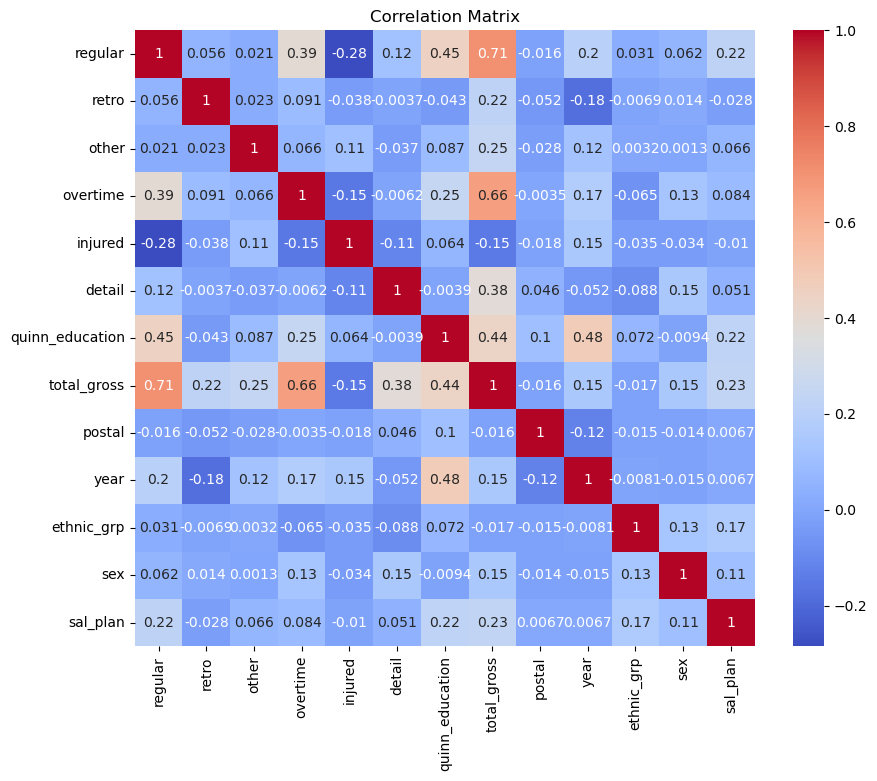

overtime           1.000000
total_gross        0.659792
regular            0.389557
quinn_education    0.251248
year               0.173538
injured            0.151705
sex                0.127559
retro              0.090793
sal_plan           0.083933
other              0.066060
ethnic_grp         0.065087
detail             0.006192
postal             0.003466
Name: overtime, dtype: float64


In [25]:


# Correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

target = 'overtime'
correlation = corr_matrix[target].abs().sort_values(ascending=False)
print(correlation)


## outlier

In [26]:
from scipy.stats import zscore

# Calculate the Z-scores for the OVERTIME column
data_full['Overtime_ZScore'] = zscore(data_full['overtime'])

# Define threshold for identifying outliers (e.g., Z-score > 3 or < -3)
outlier_threshold = 5
outliers = data_full[np.abs(data_full['Overtime_ZScore']) > outlier_threshold]
#markdown_table = outliers.to_markdown(index=False)
#print(markdown_table)

|   _id | name              | department_name          | title                          |   regular |   retro |    other |   overtime |   injured |   detail |   quinn_education |   total_gross |   postal |   year | ln,fn             | job_title                      | ethnic_grp   | sex   | sal_plan   |   Overtime_ZScore |
|------:|:------------------|:-------------------------|:-------------------------------|----------:|--------:|---------:|-----------:|----------:|---------:|------------------:|--------------:|---------:|-------:|:------------------|:-------------------------------|:-------------|:------|:-----------|------------------:|
|    10 | Barrett,Thomas E. | Boston Police Department | Police Sergeant (Det)          |    130930 | 3170.12 | 16724    |     166042 |         0 |  12515.5 |           32732.7 |        346429 |    02132 |   2021 | Barrett,Thomas E. | Police Sergeant (Det)          | WHITE        | M     | PSD        |           5.27183 |
|    15 | Barrett,Thomas E. | Boston Police Department | Police Sergeant (Det)          |    130930 | 3170.12 | 16724    |     163495 |         0 |  12515.5 |           32732.7 |        343881 |    02132 |   2022 | Barrett,Thomas E. | Police Sergeant (Det)          | WHITE        | M     | PSD        |           5.17088 |
|    10 | Barrett,Thomas E. | Boston Police Department | Police Sergeant (Det)          |    130930 | 3170.12 | 19672.8  |     180548 |         0 |  12515.5 |           32732.7 |        363884 |    02132 |   2023 | Barrett,Thomas E. | Police Sergeant (Det)          | WHITE        | M     | PSD        |           5.84669 |
|    12 | Brown,Michael A   | Boston Police Department | Police Sergeant (Det)          |    130930 | 3170.12 | 13775.1  |     172605 |         0 |  12515.5 |           32732.7 |        350043 |    02050 |   2023 | Brown,Michael A   | Police Sergeant (Det)          | WHITE        | M     | PSD        |           5.53192 |
|    17 | Johnson,Rick E    | Boston Police Department | Police Sergeant (Det)          |    127627 | 3170.12 | 19246.7  |     163204 |         0 |  12515.5 |           31906.9 |        341985 |    02072 |   2023 | Johnson,Rick E    | Police Sergeant (Det)          | BLACK        | M     | PSD        |           5.15937 |
|    40 | Medina,Richard L  | Boston Police Department | Police Sergeant (Det)          |    136699 | 3170.12 |  5776.11 |     174080 |         0 |  12515.5 |           17932.2 |        316555 |    02081 |   2023 | Medina,Richard L  | Police Sergeant (Det)          | HISPA        | M     | PSD        |           5.59034 |
|    80 | Acosta,Jose L     | Boston Police Department | Police Officer                 |    109502 | 3170.12 | 10665.1  |     174379 |         0 |  12515.5 |           17932.2 |        294546 |    01960 |   2023 | Acosta,Jose L     | Police Officer                 | HISPA        | M     | PO         |           5.6022  |
|    24 | Brown,Gregory     | Boston Police Department | Police Detective               |    111584 | 3170.12 | 16762.8  |     179948 |         0 |  12515.5 |           17932.2 |        308294 |     2301 |   2019 | Brown,Gregory     | Police Detective               | BLACK        | M     | PD         |           5.82289 |
|    99 | Acosta,Jose L     | Boston Police Department | Police Officer                 |    107498 | 3170.12 |  3203.82 |     161540 |         0 |   1840   |           17932.2 |        274083 |     1960 |   2019 | Acosta,Jose L     | Police Officer                 | HISPA        | M     | PO         |           5.09343 |
| 10699 | Kervin,Timothy M. | Boston Police Department | Police Lieutenant/Hdq Dispatch |    126188 |    0    | 18482.9  |     162651 |         0 |  18096   |           22678.8 |        348097 |    02135 |   2015 | Kervin,Timothy M. | Police Lieutenant/Hdq Dispatch | WHITE        | M     | PSO        |           5.13744 |

## model

In [27]:
# Define features and target
X = data[['total_gross', 'year', 'regular', 'sal_plan', 'injured', 'sex', 'quinn_education', 'retro']]
y = data['overtime']

# Drop NaNs if necessary (ensure the dataset is clean)
X = X.dropna()
y = y.loc[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoost model on the original (non-logged) target
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Calculate adjusted R²
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2_xgb = 1 - (1 - r2_xgb) * (n - 1) / (n - p - 1)

print("XGBoost Results (after standardization only, no log transform):")
print(f"Mean Absolute Error: {mae_xgb}")
print(f"Root Mean Squared Error: {rmse_xgb}")
print(f"R^2 Score: {r2_xgb}")
print(f"Adjusted R^2: {adj_r2_xgb}")

# Feature Importance
#xgb_importance = xgb_model.feature_importances_
#print("\nXGBoost Feature Importances:")
#for feature, importance in zip(X.columns, xgb_importance):
#    print(f"{feature}: {importance:.4f}")


XGBoost Results (after standardization only, no log transform):
Mean Absolute Error: 9496.938892360557
Root Mean Squared Error: 13706.948805400725
R^2 Score: 0.7032137799402851
Adjusted R^2: 0.7024722778289554


In [28]:
# Define features and target
X = data[['total_gross', 'year', 'regular', 'sal_plan', 'injured', 'sex', 'quinn_education', 'retro']]
y = data['overtime']

# Drop NaNs if necessary (ensure the dataset is clean)
X = X.dropna()
y = y.loc[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train CatBoost model on the original (non-logged) target
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_cat = cat_model.predict(X_test_scaled)

# Evaluation
mae_cat = mean_absolute_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2_cat = r2_score(y_test, y_pred_cat)

# Calculate adjusted R²
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2_cat = 1 - (1 - r2_cat) * (n - 1) / (n - p - 1)

print("CatBoost Results (after standardization only, no log transform):")
print(f"Mean Absolute Error: {mae_cat}")
print(f"Root Mean Squared Error: {rmse_cat}")
print(f"R^2 Score: {r2_cat}")
print(f"Adjusted R^2: {adj_r2_cat}")

# Feature Importance
#cat_importance = cat_model.get_feature_importance()
#print("\nCatBoost Feature Importances:")
#for feature, importance in zip(X.columns, cat_importance):
#    print(f"{feature}: {importance:.4f}")

CatBoost Results (after standardization only, no log transform):
Mean Absolute Error: 9177.450660797644
Root Mean Squared Error: 13074.60704499018
R^2 Score: 0.7299653834118773
Adjusted R^2: 0.7292907185359545


In [29]:
# Example features and target
X = data[['year', 'total_gross', 'sal_plan', 'ethnic_grp', 'sex']]
y = data['overtime']

# Drop NaNs and align target
X = X.dropna()
y = y.loc[X.index]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
}

print("Model Evaluation Results:\n")

# Number of observations and predictors for adjusted R² calculation
n = X_test.shape[0]
p = X_test.shape[1]

for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"{name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}")
    print(f"  Adjusted R2: {adj_r2:.4f}\n")


Model Evaluation Results:

LinearRegression:
  MAE: 13658.8991
  RMSE: 18045.8465
  R2: 0.4856
  Adjusted R2: 0.4848

Ridge:
  MAE: 13658.9609
  RMSE: 18045.8953
  R2: 0.4856
  Adjusted R2: 0.4848

RandomForest:
  MAE: 11694.5720
  RMSE: 15919.1100
  R2: 0.5997
  Adjusted R2: 0.5991

XGBoost:
  MAE: 11211.4903
  RMSE: 15126.0424
  R2: 0.6386
  Adjusted R2: 0.6380

CatBoost:
  MAE: 10982.5958
  RMSE: 14655.0844
  R2: 0.6607
  Adjusted R2: 0.6602



In [31]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam


# Define a simple neural network model
def create_model(input_dim):
    model = keras.Sequential()
    # First hidden layer
    model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,)))
    # Second hidden layer
    model.add(layers.Dense(64, activation='relu'))
    # Output layer for regression (no activation)
    model.add(layers.Dense(1))
    return model

# Create the model
model = create_model(input_dim=X_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # 'mse' is common for regression

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Optional: for monitoring validation metrics
    epochs=50,
    batch_size=32,
    verbose=1
)

# Predictions with the trained neural network
y_pred_nn = model.predict(X_test).flatten()

# Evaluation
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("\nNeural Network Results:")
print(f"Mean Absolute Error: {mae_nn}")
print(f"Root Mean Squared Error: {rmse_nn}")
print(f"R^2 Score: {r2_nn}")


Epoch 1/50
322/322 [==============================] - 0s 648us/step - loss: 404906912.0000 - val_loss: 376336960.0000
Epoch 2/50
322/322 [==============================] - 0s 491us/step - loss: 384367232.0000 - val_loss: 351680960.0000
Epoch 3/50
322/322 [==============================] - 0s 492us/step - loss: 376491488.0000 - val_loss: 355703808.0000
Epoch 4/50
322/322 [==============================] - 0s 488us/step - loss: 372359712.0000 - val_loss: 352454848.0000
Epoch 5/50
322/322 [==============================] - 0s 574us/step - loss: 369102592.0000 - val_loss: 338668352.0000
Epoch 6/50
322/322 [==============================] - 0s 506us/step - loss: 359293824.0000 - val_loss: 328974432.0000
Epoch 7/50
322/322 [==============================] - 0s 532us/step - loss: 354295040.0000 - val_loss: 396035232.0000
Epoch 8/50
322/322 [==============================] - 0s 547us/step - loss: 355764352.0000 - val_loss: 315485856.0000
Epoch 9/50
322/322 [==============================] - 0s